/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 69s 12ms/step - loss: 0.0025 - val_loss: 7.4808e-04
Epoch 2/50
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 66s 11ms/step - loss: 8.9959e-04 - val_loss: 6.6041e-04
Epoch 3/50
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - loss: 8.3390e-04 - val_loss: 6.4864e-04
Epoch 4/50
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step - loss: 8.1125e-04 - val_loss: 6.9019e-04
Epoch 5/50
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 7.9136e-04 - val_loss: 6.8072e-04
Epoch 6/50
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 7.8019e-04 - val_loss: 6.1525e-04
Epoch 7/50
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 7.7409e-04 - val_loss: 6.9807e-04
Epoch 8/50
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 7.6940e-04 - val_loss: 6.2443e-04
Epoch 9/50
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 7.5872e-04 - val_loss: 6.2983e-04
Epoch 10/50
5714/5714 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 7.5573e-04 - val_loss: 6.0773e-04
Epoch 11/50
5714/5714 ━

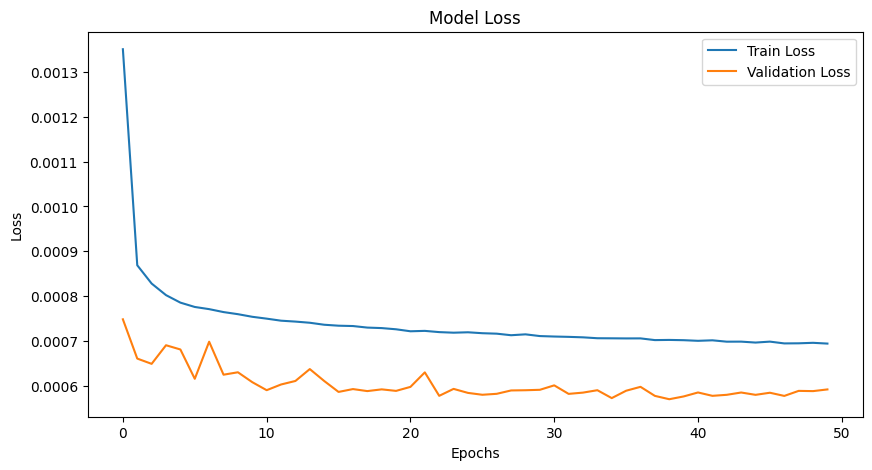

1429/1429 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


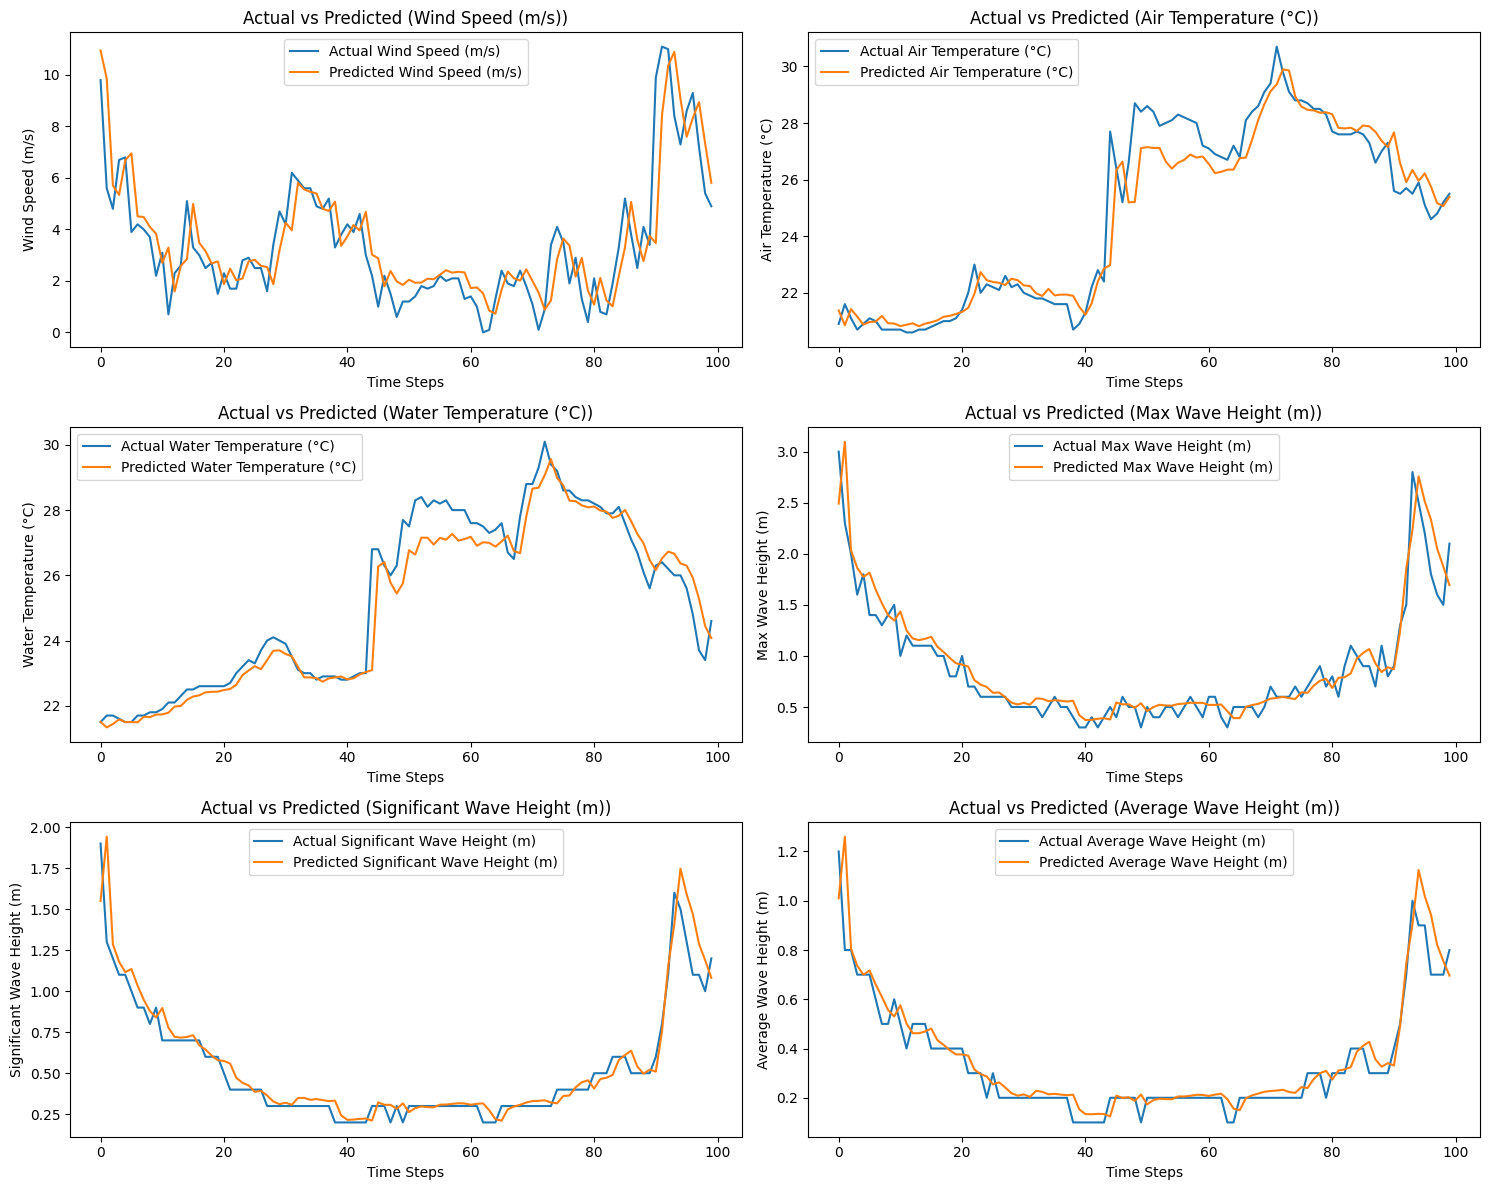

In [ ]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt

# 1. 데이터 로드
file_path = '/content/OBS_BUOY_TIM_20241214230227.csv'  # CSV 파일 경로

# 인코딩 방식 지정
data = pd.read_csv(file_path, encoding='cp949')  # 또는 'euc-kr'

# 2. 필요한 열 선택 및 전처리
# 필요한 열만 선택
data = data[['풍속(m/s)', '기온(°C)', '수온(°C)', '최대파고(m)', '유의파고(m)', '평균파고(m)', '파주기(sec)']]

# 결측치 처리
data = data.dropna()

# 3. 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 4. 시계열 데이터 준비 (입력 데이터와 출력 데이터 분리)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # 입력: 36개의 데이터
        y.append(data[i + seq_length])   # 출력: 1개의 데이터 (다음 시점의 데이터)
    return np.array(X), np.array(y)

seq_length = 36  # 입력 길이 (36개 데이터)
X, y = create_sequences(scaled_data, seq_length)

# 5. 데이터 분리 (훈련/테스트)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 6. Bi-GRU 모델 구성
model = Sequential()
model.add(Bidirectional(GRU(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # 과적합 방지를 위한 Dropout 레이어
model.add(Bidirectional(GRU(64, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))  # 출력 노드 수 = 1 x feature 수
model.compile(optimizer='adam', loss='mean_squared_error')

# 7. 모델 학습
history = model.fit(X_train, y_train,
                    epochs=50, batch_size=32,
                    validation_data=(X_test, y_test))

# 8. 학습 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 9. 예측 및 결과 복원
predicted = model.predict(X_test)  # (batch_size, feature 수)
predicted_rescaled = scaler.inverse_transform(predicted)  # 예측 데이터 복원
y_test_rescaled = scaler.inverse_transform(y_test)        # 실제 데이터 복원


# Visualization of 6 Features Comparison
feature_names = ['Wind Speed (m/s)', 'Air Temperature (°C)', 'Water Temperature (°C)',
                 'Max Wave Height (m)', 'Significant Wave Height (m)', 'Average Wave Height (m)']

plt.figure(figsize=(15, 12))

for i in range(6):  # Loop through 6 features
    plt.subplot(3, 2, i + 1)  # Create a 3x2 grid of subplots
    plt.plot(y_test_rescaled[:100, i], label=f'Actual {feature_names[i]}')
    plt.plot(predicted_rescaled[:100, i], label=f'Predicted {feature_names[i]}')
    plt.title(f'Actual vs Predicted ({feature_names[i]})')
    plt.xlabel('Time Steps')
    plt.ylabel(feature_names[i])
    plt.legend()

plt.tight_layout()
plt.show()

